# TODO:
- write report


- (Optional) check if classification is better
- (Optional) preprocess of  product description by bullets/ removing words with number

# Practical Deep Learning Workshop 2021
## Assignment 3 - Word Embeddings
 
### Authors:
 
1.   Chen Doytshman 205644941
2.   Naor Kolet 205533060


# 0. Preliminary

## a. Imports

In [56]:
import pandas as pd
import numpy as np
 
# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate
from tensorflow.keras.layers import Dropout, Dense, Lambda, Multiply, Subtract, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Activation, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# XGBoost
from xgboost import XGBRegressor

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
import os
import joblib
import random
import time
from tqdm import tqdm_notebook as tqdm

SEED = 42
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 100)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
import zipfile
DATA_DIR = 'home-depot-product-search-relevance'

files = [f for f in os.listdir(DATA_DIR) if f.endswith('zip')]
for file in tqdm(files):
    with zipfile.ZipFile(f'{DATA_DIR}/{file}') as zf:
        zf.extractall(DATA_DIR)
        os.remove(f'{DATA_DIR}/{file}')

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

## b. Collecting Results
throughout this notebook we are going to collect the results for the different models, on-the-fly. Later, we will discuss them in section 3 of this assignment.

In [214]:
from prettytable import PrettyTable
results = PrettyTable(['Model type', 'Runtime', 'Train RMSE',
                       'Val-RMSE', 'Test-RMSE', 'Train MAE', 
                       'Val-MAE', 'Test-MAE'], hrules=True)
results.float_format = ".4"

## c. Data Preparation, EDA

Let's load the data:

In [5]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv', index_col='id', encoding='latin-1')
product_desc_df = pd.read_csv(f'{DATA_DIR}/product_descriptions.csv', index_col='product_uid')
attributes_df = pd.read_csv(f'{DATA_DIR}/attributes.csv', index_col=['product_uid'], dtype={'product_uid': 'Int64'})

In [6]:
test_path = f'{DATA_DIR}/test_labels.csv'
if os.path.exists(test_path):
    test_df = pd.read_csv(test_path)
else:
    test_df = pd.read_csv(f'{DATA_DIR}/test.csv', index_col='id', encoding='latin-1')
    sol = pd.read_csv(f'{DATA_DIR}/solution.csv', index_col='id', encoding='latin-1')
    test_df = test_df[sol.relevance != -1]
    test_df = test_df.join(sol.relevance, on='id')
    test_df.to_csv(test_path)

In [7]:
train_df.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),shower only faucet,2.67


In [8]:
product_counts = train_df.groupby('product_uid').count()['search_term'].value_counts()

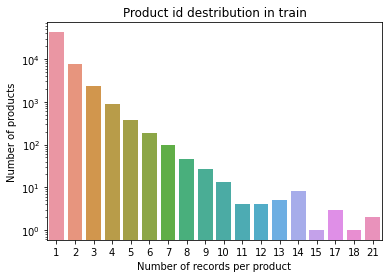

In [9]:
ax = sns.barplot(x=product_counts.index, y=product_counts.values)
ax.set_yscale('log')
ax.set_xlabel('Number of records per product')
ax.set_ylabel('Number of products')
_ = ax.set_title('Product id destribution in train')

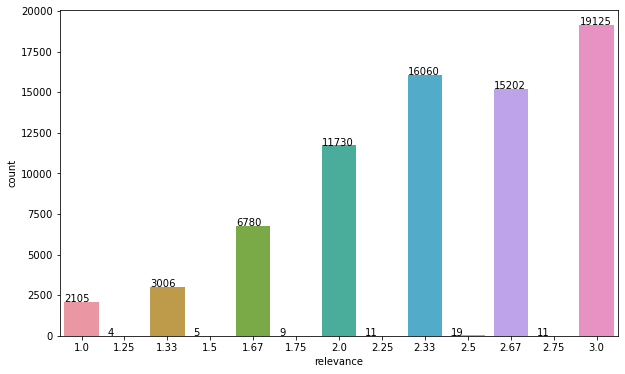

In [10]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=train_df, x="relevance")

relevance_values = train_df["relevance"].value_counts().sort_index()

for p, label in zip(ax.patches, relevance_values):
    ax.annotate(label, (p.get_x(), p.get_height()+0.5))

In [11]:
product_desc_df.head()

,product_description
product_uid,
100001,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Si..."
100002,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, wea..."
100003,"Classic architecture meets contemporary design in the Ensemble Curve series, made of solid Vikre..."
100004,The Grape Solar 265-Watt Polycrystalline PV Solar Panel bonus pack bundles 4 Grape Solar 265-Wat...
100005,Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has ...


In [59]:
product_desc_df.iloc[0, 0]

'Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws'

In [60]:
attributes_df[attributes_df.index.isin([100001])]

,name,value
product_uid,,
100001,Bullet01,Versatile connector for various 90° connections and home repair projects
100001,Bullet02,Stronger than angled nailing or screw fastening alone
100001,Bullet03,Help ensure joints are consistently straight and strong
100001,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
100001,Bullet05,Made from 12-Gauge steel
100001,Bullet06,Galvanized for extra corrosion resistance
100001,Bullet07,Install with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws
100001,Gauge,12
100001,Material,Galvanized Steel


## d. Preprocessing

In this step we directed a few issues.

- We observed the product description and the attribute tables. We saw that all the data from the attribute table is in the product description and not all the products have records in the attribute table so we will use only the product descriptions.
- We observed that the product description have some words that got 'sticked' together, for example ```aloneHelp```, we will split those words.
- The product description does not always contain the product name so  we will concat those two.

In [14]:
del attributes_df

In [74]:
import re

def striphtml(data): 
    cleanr = re.compile('<.*?>') 
    cleantext = re.sub(cleanr, ' ', data) 
    cleanr = re.compile('&nbsp;') 
    cleantext = re.sub(cleanr, ' ', cleantext) 
    return cleantext

def camel_case_split(data):
    matches = re.finditer('.+?(?:(?<=[a-z,(,)])\.?\s?(?=[A-Z])|(?<=[A-Z,(,)])\.?\s?(?=[A-Z][a-z])|(?<=[A-Z,a-z,(,)])\.?\s?(?=[0-9])|$)', data)
    return ' '.join([m.group(0).strip() for m in matches])

from nltk.stem.porter import PorterStemmer
# from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


# wml = WordNetLemmatizer()
ps = PorterStemmer()
sw = set(stopwords.words('english'))

def stemming(data):
    tokens = word_tokenize(data)
    stemmed_data = []
    
    for t in tokens:
        # Use only words, character combinations and numbers 
        if (not t.isalpha() and not t.isnumeric()) and len(t) == 1: 
            continue
            
        # Lower case word
        t = t.lower()
        
        # Remove stop words
        if t in sw: 
            continue
        
        # Stem word
        stem_t = ps.stem(t) 
#         stem_t = wml.lemmatize(t)
        
        stemmed_data.append(stem_t)
        
    return ' '.join(stemmed_data)

def preprocess_description(data):
    cleared_text = camel_case_split(striphtml(data)).replace('  ', ' ')
    stemmed_text = stemming(cleared_text)
    return stemmed_text

In [75]:
product_desc_df.iloc[1,0]

'BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coating for your tired and worn out deck, rejuvenating to a whole new look.  For the best results, be sure to properly prepare the surface using other applicable BEHR products displayed above.California residents: see&nbsp;Proposition 65 informationRevives wood and composite decks, railings, porches and boat docks, also great for concrete pool decks, patios and sidewalks100% acrylic solid color coatingResists cracking and peeling and conceals splinters and cracks up to 1/4 in.Provides a durable, mildew resistant finishCovers up to 75 sq. ft. in 2 coats per gallonCreates a textured, slip-resistant finishFor best results, prepare with the appropriate BEHR product for your wood or concrete surfaceActual paint colors may vary from on-screen and printer representationsColors available to be tinted in 

In [76]:
preprocess_description(product_desc_df.iloc[1,0])

'behr premium textur deckov innov solid color coat bring old weather wood concret back life advanc 100 acryl resin formula creat durabl coat tire worn deck rejuven whole new look best result sure properli prepar surfac use applic behr product display california resid see proposit 65 inform reviv wood composit deck rail porch boat dock also great concret pool deck patio sidewalk 100 acryl solid color coat resist crack peel conceal splinter crack 1/4 provid durabl mildew resist finish cover 75 sq ft. 2 coat per gallon creat textur slip-resist finish best result prepar appropri behr product wood concret surfac actual paint color may vari on-screen printer represent color avail tint store onlin price includ paint care fee follow state ca co ct mn ri vt'

In [82]:
def join_desc(df):
    df = df.join(product_desc_df['product_description'], on='product_uid')
    df['product_description'] = df['product_title'] + ' . ' + df['product_description']
    df['product_description'] = df['product_description'].apply(preprocess_description)
    df = df[['product_uid', 'search_term', 'product_description', 'relevance']]
    return df

train_df = join_desc(train_df)
test_df = join_desc(test_df)

In [211]:
train_df, val_df = train_test_split(train_df,
                                    test_size=0.3,
                                    random_state=SEED)

In [212]:
train_x = train_df[['search_term', 'product_description']]
train_y = train_df[['relevance']]

scale_y = MinMaxScaler().fit(train_y)
train_y = scale_y.transform(train_y).reshape(-1)

In [213]:
val_x = val_df[['search_term', 'product_description']]
val_y = scale_y.transform(val_df[['relevance']]).reshape(-1)
test_x = test_df[['search_term', 'product_description']]
test_y = scale_y.transform(test_df[['relevance']]).reshape(-1)

# 1. Character level LSTM

## Using character level processing to predict search relevance

### a. Preprocess the data to contain sequences of single characters

In [215]:
def tokenize_serie(serie, pad):
    serie = pd.Series(map(lambda x: [ord(char) for word in word_tokenize(x) for char in word], serie.values), index=serie.index)
    return pad_sequences(serie, pad, padding='post')

In [216]:
def prepare_x_char(df):
    ST_PAD = 60
    DESC_PAD = 1500
    search_term = tokenize_serie(df['search_term'], ST_PAD)
    description = tokenize_serie(df['product_description'], DESC_PAD)
    
    search_term, description = map(lambda x: np.expand_dims(x,axis=2), [search_term, description])
    return search_term, description

In [217]:
train_x_char = prepare_x_char(train_x)
val_x_char = prepare_x_char(val_x)
test_x_char = prepare_x_char(test_x)

In [218]:
max_char = max(train_x_char[0].max(), train_x_char[1].max())

def scale_x(st, pd):
    return st/max_char, pd/max_char

train_x_char = scale_x(*train_x_char)
val_x_char = scale_x(*val_x_char)
test_x_char = scale_x(*test_x_char)

### b. Constructing a Siamese network

https://github.com/prabhnoor0212/Siamese-Network-Text-Similarity

#TODO: Remove extra functions

In [219]:
from tensorflow.keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [220]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [221]:
sm = 0

def common_model(length):
    global sm
    inp = Input(shape=(length, 1))
    X = Conv1D(64, 10, activation='relu')(inp)
    X = MaxPooling1D()(X)
    X = Flatten()(X)
    X = Activation('relu')(X)
    X = Dense(128, activation='relu')(X)
    
    sm += 1
    return Model(inp, X, name=f'siamese_model_{sm}')

In [222]:
common_model(128).summary()

Model: "siamese_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 1)]          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 119, 64)           704       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3776)              0         
_________________________________________________________________
activation_5 (Activation)    (None, 3776)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               483456    
Total params: 484,160
Trainable params: 484,160
Non-trainable params: 0
_____________________________________________

In [291]:
def init_siamese_model(search_term_len, product_description_len, output_shape=1):
    input_1 = Input(shape=(search_term_len, 1))
    input_2 = Input(shape=(product_description_len, 1))
    
    lstm_1 = LSTM(128)(input_1)
    lstm_2 = LSTM(128)(input_2)
    
    expand_layer = Lambda(lambda tensor: tensor[...,np.newaxis],name="expand_dim_layer")
    
    expended_1 = expand_layer(lstm_1)
    expended_2 = expand_layer(lstm_2)
    
    sm = common_model(128)

    vector_1 = sm(expended_1)
    
    vector_2 = sm(expended_2)
    
    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
    
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(conc)
    x = Dropout(0.01)(x)
    out = Dense(output_shape, activation="sigmoid", name = 'out')(x)

    model = Model([input_1, input_2], out)

    model.compile(loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer=Adam())
    
    return model

In [292]:
init_siamese_model(train_x_char[0].shape[1],train_x_char[1].shape[1]).summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 1500, 1)]    0                                            
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 256)          264192      input_27[0][0]                   
__________________________________________________________________________________________________
lstm_17 (LSTM)                  (None, 256)          264192      input_28[0][0]                   
___________________________________________________________________________________________

#### Training framework

In [225]:
def get_callbacks(model_name):
    acc = 'val_loss'
    acc_mode = 'min'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=1, patience=6)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR, earlystop]

In [226]:
def train_model(model_gen, train_data, val_data, batch_size=128, use_saved=False):
    os.makedirs('./models', exist_ok=True)
    model_name = model_gen.__name__[5:]
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
        
        (train_st, train_desc), train_rel = train_data
        model = model_gen(train_st.shape[1],train_desc.shape[1])
        history = model.fit(
                            x=[train_st, train_desc],
                            y=train_rel,
                            batch_size=batch_size,
                            epochs=20,
                            validation_data=val_data,
                            callbacks=callbacks
                            )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')
    
    return model, history

In [227]:
def visualize_perf(history):
    fig, ax = plt.subplots(ncols=2, figsize=(5*2,5))
    fig.suptitle(f'Model performance over epochs')
    
    for k in ['rmse', 'val_rmse']:
        ax[0].plot(history[k])
        
    ax[0].legend(['train_rmse', 'val_rmse'])
    ax[0].margins(0.01)
    ax[0].set_title('rmse')
    
    for k in ['mae', 'val_mae']:
        ax[1].plot(history[k])
        
    ax[1].legend(['train_mae', 'val_mae'])
    ax[1].margins(0.01)
    ax[1].set_title('mae')
    
    plt.show()


In [228]:
def evaluate_model(model, x, y):
    preds = model.predict(x)
    
    preds_mse = mean_squared_error(preds, y)
    preds_mae = mean_absolute_error(preds, y)
    preds_rmse = mean_squared_error(preds, y, squared=False)
    
    return preds_mse, preds_mae, preds_rmse

In [293]:
start = time.time()
char_model, char_history = train_model(init_siamese_model,
                                       (train_x_char, train_y),
                                       (val_x_char, val_y),
                                       use_saved=False)
end = time.time()

Epoch 1/20
325/325 [==============================] - 38s 118ms/step - loss: 0.0734 - mae: 0.2227 - rmse: 0.2710 - val_loss: 0.0723 - val_mae: 0.2202 - val_rmse: 0.2689 - lr: 0.0010
Epoch 2/20
325/325 [==============================] - 38s 116ms/step - loss: 0.0712 - mae: 0.2187 - rmse: 0.2668 - val_loss: 0.0723 - val_mae: 0.2199 - val_rmse: 0.2689 - lr: 0.0010
Epoch 3/20
325/325 [==============================] - 38s 117ms/step - loss: 0.0712 - mae: 0.2189 - rmse: 0.2668 - val_loss: 0.0724 - val_mae: 0.2195 - val_rmse: 0.2691 - lr: 0.0010
Epoch 4/20
325/325 [==============================] - 38s 117ms/step - loss: 0.0710 - mae: 0.2188 - rmse: 0.2665 - val_loss: 0.0723 - val_mae: 0.2201 - val_rmse: 0.2689 - lr: 0.0010
Epoch 5/20
325/325 [==============================] - 38s 117ms/step - loss: 0.0710 - mae: 0.2188 - rmse: 0.2665 - val_loss: 0.0723 - val_mae: 0.2202 - val_rmse: 0.2689 - lr: 0.0010
Epoch 6/20
325/325 [==============================] - ETA: 0s - loss: 0.0710 - mae: 0.2187

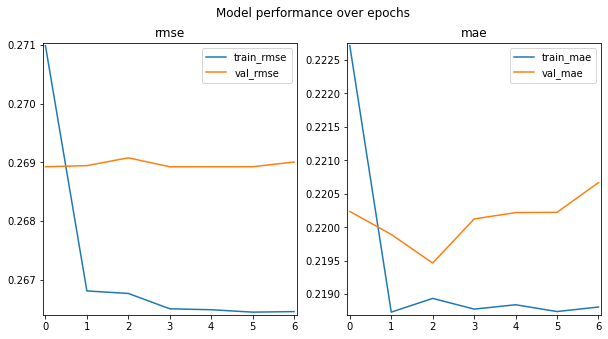

In [294]:
visualize_perf(char_history)

In [295]:
train_mse, train_mae, train_rmse =  evaluate_model(char_model, train_x_char, train_y)

print(f'MSE of {train_mse:.4f} on the train')
print(f'MAE of {train_mae:.4f} on the train')
print(f'RMSE of {train_rmse:.4f} on the train')

MSE of 0.0710 on the train
MAE of 0.2187 on the train
RMSE of 0.2664 on the train


In [296]:
val_mse, val_mae, val_rmse =  evaluate_model(char_model, val_x_char, val_y)

print(f'MSE of {val_mse:.4f} on the val')
print(f'MAE of {val_mae:.4f} on the val')
print(f'RMSE of {val_rmse:.4f} on the val')

MSE of 0.0723 on the val
MAE of 0.2202 on the val
RMSE of 0.2689 on the val


In [297]:
test_mse, test_mae, test_rmse =  evaluate_model(char_model, test_x_char, test_y)

print(f'MAE loss on test set: {test_mse:.4f}')
print(f'MSE loss on test set: {test_mse:.4f}')
print(f'RMSE loss on test set: {test_rmse:.4f}')

MAE loss on test set: 0.0716
MSE loss on test set: 0.0716
RMSE loss on test set: 0.2676


In [234]:
runtime = end - start

results.add_row(['LSTM (character level)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

### c. Naïve model-based benchmark with ```CountVectorizer```

TODO: MARKDOWN

#### Preprocessing

In [235]:
desc_series = train_df['product_description']
search_term_series = train_df['search_term']
desc_st = pd.concat([desc_series, search_term_series])
corpus = desc_st.values
vectorizer = CountVectorizer(analyzer='char')
vectorizer.fit(corpus)
print(vectorizer.get_feature_names())

[' ', '$', '&', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '\\', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x89', '¡', '¢', 'ª', 'ã', 'å', 'è', 'ê', 'ò', '÷', 'û']


In [236]:
def prepare_x_naive(df):
    desc_series = df['product_description']
    search_term_series = df['search_term']
    counts_desc = vectorizer.transform(desc_series).toarray()
    counts_st = vectorizer.transform(search_term_series).toarray()
    X = np.concatenate([counts_desc, counts_st], axis=1)
    return X

In [237]:
train_x_charvec  = prepare_x_naive(train_x)
val_x_charvec = prepare_x_naive(val_x)
test_x_charvec = prepare_x_naive(test_x)

In [238]:
use_saved = False
rfr_path = 'models/rfr.sav'

if use_saved:
    rfr = joblib.load(rfr_path)
else:
    rfr = RandomForestRegressor(random_state=SEED, verbose=0, n_jobs=-1)
    start = time.time()
    rfr.fit(train_x_charvec, train_y)
    end = time.time()
    joblib.dump(rfr, rfr_path)

In [239]:
train_mse, train_mae, train_rmse =  evaluate_model(rfr, train_x_charvec, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0090 on the train
Got MAE of 0.0765 on the train
Got RMSE of 0.0947 on the train


In [240]:
val_mse, val_mae, val_rmse =  evaluate_model(rfr, val_x_charvec, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0638 on the val
Got MAE of 0.2055 on the val
Got RMSE of 0.2525 on the val


In [241]:
test_mse, test_mae, test_rmse =  evaluate_model(rfr, test_x_charvec, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0687 on the test
Got MAE of 0.2144 on the test
Got RMSE of 0.2621 on the test


In [242]:
runtime = end - start

results.add_row(['Naïve benchmark (section 1c)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

### d. Using our model as a feature extractor

In [243]:
fe_char_model = Model(char_model.input, char_model.layers[-3].output)

In [244]:
train_features = fe_char_model.predict(train_x_char)
val_features = fe_char_model.predict(val_x_char)
test_features = fe_char_model.predict(test_x_char)

In [245]:
use_saved = False

fe_rfr_path = 'models/fe_char_rfr.sav'
fe_xgb_path = 'models/fe_char_xgb.sav'

if use_saved:
    rfr_model = joblib.load(fe_rfr_path)
    xgb_model = joblib.load(fe_xgb_path)
else:
    xgb_model = XGBRegressor(use_label_encoder=False, n_jobs=-1)
    rfr_model = RandomForestRegressor(random_state=SEED, verbose=0, n_jobs=-1)

    print('training xgb')
    start_xgb = time.time()
    xgb_model.fit(train_features, train_y)
    end_xgb = time.time()
    print('training rfr')
    start_rfr = time.time()
    rfr_model.fit(train_features, train_y)
    end_rfr = time.time()

    joblib.dump(rfr_model, fe_rfr_path)
    joblib.dump(xgb_model, fe_xgb_path)

training xgb
training rfr


#### Evaluating RandomForest

In [246]:
train_mse, train_mae, train_rmse =  evaluate_model(rfr_model, train_features, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0682 on the train
Got MAE of 0.2130 on the train
Got RMSE of 0.2611 on the train


In [247]:
val_mse, val_mae, val_rmse =  evaluate_model(rfr_model, val_features, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0715 on the val
Got MAE of 0.2187 on the val
Got RMSE of 0.2675 on the val


In [248]:
test_mse, test_mae, test_rmse =  evaluate_model(rfr_model, test_features, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0724 on the test
Got MAE of 0.2205 on the test
Got RMSE of 0.2690 on the test


In [249]:
runtime = end_rfr - start_rfr

results.add_row(['Random Forest (character LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

#### Evaluating XGBoost

In [250]:
train_mse, train_mae, train_rmse =  evaluate_model(xgb_model, train_features, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0567 on the train
Got MAE of 0.1940 on the train
Got RMSE of 0.2381 on the train


In [251]:
val_mse, val_mae, val_rmse =  evaluate_model(xgb_model, val_features, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0681 on the val
Got MAE of 0.2136 on the val
Got RMSE of 0.2610 on the val


In [252]:
test_mse, test_mae, test_rmse =  evaluate_model(xgb_model, test_features, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0725 on the test
Got MAE of 0.2201 on the test
Got RMSE of 0.2693 on the test


In [253]:
runtime = end_xgb - start_xgb

results.add_row(['XGBoost (character LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

# 2. Word embeddings and word level LSTM

## Using word/character-combination level processing to predict search relevance

### a. Preprocess the data to create tokens of words/character-combinations

In [254]:
desc_series = train_x['product_description']
search_term_series = train_x['search_term']
desc_st = pd.concat([desc_series, search_term_series])

In [255]:
def tokenize_words(serie, pad):
    serie = pd.Series(tokenizer.texts_to_sequences(serie.values), index=serie.index)
    return pad_sequences(serie, pad, padding='post')

In [256]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_st)

In [257]:
DESC_PAD = 933
ST_PAD = 17

In [258]:
train_desc_padded = tokenize_words(train_df['product_description'], DESC_PAD)
train_st_padded = tokenize_words(train_df['search_term'], ST_PAD)

In [259]:
val_desc_padded = tokenize_words(val_df['product_description'], DESC_PAD)
val_st_padded = tokenize_words(val_df['search_term'], ST_PAD)

In [260]:
test_desc_padded = tokenize_words(test_df['product_description'], DESC_PAD)
test_st_padded = tokenize_words(test_df['search_term'], ST_PAD)

### b. Create embeddings

In [261]:
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin'

if not os.path.isfile(EMBEDDING_FILE):
    !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [262]:
!gzip -f -d GoogleNews-vectors-negative300.bin.gz

gzip: GoogleNews-vectors-negative300.bin.gz: No such file or directory


In [263]:
from gensim import models

embeddings_index = models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
embed_size = 300
word_index = tokenizer.word_index
max_features = len(word_index) + 1

nb_words = min(len(word_index), len(word_index))
embedding_matrix = (np.random.rand(nb_words+1, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= max_features: continue
    if word in embeddings_index:
        embedding_vector = embeddings_index.get_vector(word)
        embedding_matrix[i] = embedding_vector

### c. Constructing a Siamese network

In [264]:
def init_siamese_model_words(search_term_len, product_description_len, output_shape=1):
    input_1 = Input(shape=(search_term_len,))
    input_2 = Input(shape=(product_description_len,))
    
    embd1 = Embedding(max_features, 
                      embed_size, 
                      weights=[embedding_matrix],
                      input_length=search_term_len,
                      name='search_embd')(input_1)
    
    embd2 = Embedding(max_features,
                      embed_size,
                      weights=[embedding_matrix],
                      input_length=product_description_len,
                      name='desc_embd')(input_2)
    
    lstm_1 = LSTM(128)(embd1)
    lstm_2 = LSTM(128)(embd2)
    
    expand_layer = Lambda(lambda tensor: tensor[...,np.newaxis],name="expand_dim_layer")
    
    expended_1 = expand_layer(lstm_1)
    expended_2 = expand_layer(lstm_2)
    
    sm = common_model(128)

    vector_1 = sm(expended_1)
    
    vector_2 = sm(expended_2)
    
    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
    
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(conc)
    x = Dropout(0.01)(x)
    out = Dense(output_shape, activation="sigmoid", name = 'out')(x)

    model = Model([input_1, input_2], out)
    
    model.get_layer('search_embd').trainable = False
    model.get_layer('desc_embd').trainable = False

    model.compile(loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer=Adam())
    
    return model

In [265]:
init_siamese_model_words(train_st_padded.shape[1],train_desc_padded.shape[1]).summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 17)]         0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 933)]        0                                            
__________________________________________________________________________________________________
search_embd (Embedding)         (None, 17, 300)      10413000    input_21[0][0]                   
__________________________________________________________________________________________________
desc_embd (Embedding)           (None, 933, 300)     10413000    input_22[0][0]                   
____________________________________________________________________________________________

In [266]:
train_data = ((train_st_padded, train_desc_padded), train_y)
val_data = ((val_st_padded, val_desc_padded), val_y)
start = time.time()
word_model, word_history = train_model(init_siamese_model_words, train_data, val_data, use_saved=False)
end = time.time()

Epoch 1/20
325/325 [==============================] - 32s 98ms/step - loss: 0.0723 - mae: 0.2208 - rmse: 0.2688 - val_loss: 0.0724 - val_mae: 0.2209 - val_rmse: 0.2690 - lr: 0.0010
Epoch 2/20
325/325 [==============================] - 31s 97ms/step - loss: 0.0702 - mae: 0.2177 - rmse: 0.2649 - val_loss: 0.0716 - val_mae: 0.2189 - val_rmse: 0.2675 - lr: 0.0010
Epoch 3/20
325/325 [==============================] - 31s 97ms/step - loss: 0.0682 - mae: 0.2149 - rmse: 0.2612 - val_loss: 0.0696 - val_mae: 0.2193 - val_rmse: 0.2639 - lr: 0.0010
Epoch 4/20
325/325 [==============================] - 30s 94ms/step - loss: 0.0665 - mae: 0.2118 - rmse: 0.2579 - val_loss: 0.0697 - val_mae: 0.2122 - val_rmse: 0.2640 - lr: 0.0010
Epoch 5/20
325/325 [==============================] - 32s 97ms/step - loss: 0.0654 - mae: 0.2095 - rmse: 0.2557 - val_loss: 0.0679 - val_mae: 0.2122 - val_rmse: 0.2605 - lr: 0.0010
Epoch 6/20
325/325 [==============================] - 32s 97ms/step - loss: 0.0639 - mae: 0.206

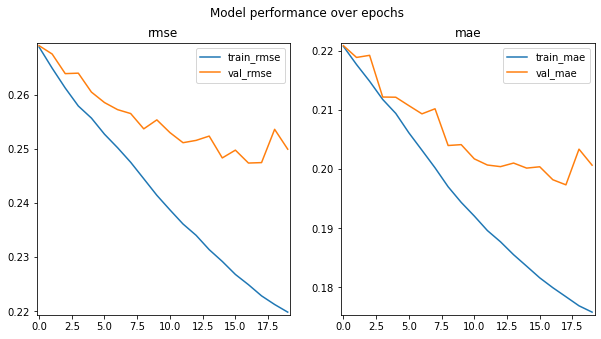

In [267]:
visualize_perf(word_history)

In [268]:
train_mse, train_mae, train_rmse = evaluate_model(word_model, [train_st_padded, train_desc_padded], train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0489 on the train
Got MAE of 0.1769 on the train
Got RMSE of 0.2212 on the train


In [269]:
val_mse, val_mae, val_rmse = evaluate_model(word_model, [val_st_padded, val_desc_padded], val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0612 on the val
Got MAE of 0.1982 on the val
Got RMSE of 0.2474 on the val


In [270]:
test_mse, test_mae, test_rmse = evaluate_model(word_model, [test_st_padded, test_desc_padded], test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0725 on the test
Got MAE of 0.2162 on the test
Got RMSE of 0.2693 on the test


In [271]:
runtime = end - start

results.add_row(['LSTM (word level)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

### d. Using our model as a feature extractor

In [272]:
fe_word_model = Model(word_model.input, word_model.layers[-3].output)

In [273]:
train_features = fe_word_model.predict([train_st_padded, train_desc_padded])
val_features = fe_word_model.predict([val_st_padded, val_desc_padded])
test_features = fe_word_model.predict([test_st_padded, test_desc_padded])

In [274]:
use_saved = False

fe_rfr_path = 'models/fe_word_rfr.sav'
fe_xgb_path = 'models/fe_word_xgb.sav'

if use_saved:
    rfr_model = joblib.load(fe_rfr_path)
    xgb_model = joblib.load(fe_xgb_path)
else:
    xgb_model = XGBRegressor(use_label_encoder=False, n_jobs=-1)
    rfr_model = RandomForestRegressor(random_state=SEED, verbose=0, n_jobs=-1)

    print('training xgb')
    start_xgb = time.time()
    xgb_model.fit(train_features, train_y)
    end_xgb = time.time()
    print('training rfr')
    start_rfr = time.time()
    rfr_model.fit(train_features, train_y)
    end_rfr = time.time()

    joblib.dump(rfr_model, fe_rfr_path)
    joblib.dump(xgb_model, fe_xgb_path)

training xgb
training rfr


#### Evaluating RandomForest

In [275]:
train_mse, train_mae, train_rmse = evaluate_model(rfr_model, train_features, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0347 on the train
Got MAE of 0.1442 on the train
Got RMSE of 0.1862 on the train


In [276]:
val_mse, val_mae, val_rmse = evaluate_model(rfr_model, val_features, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0621 on the val
Got MAE of 0.1949 on the val
Got RMSE of 0.2492 on the val


In [277]:
test_mse, test_mae, test_rmse = evaluate_model(rfr_model, test_features, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0786 on the test
Got MAE of 0.2239 on the test
Got RMSE of 0.2803 on the test


In [278]:
runtime = end_rfr - start_rfr

results.add_row(['Random Forest (word LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

#### Evaluating XGBoost

In [279]:
train_mse, train_mae, train_rmse = evaluate_model(xgb_model, train_features, train_y)

print(f'Got MSE of {train_mse:.4f} on the train')
print(f'Got MAE of {train_mae:.4f} on the train')
print(f'Got RMSE of {train_rmse:.4f} on the train')

Got MSE of 0.0404 on the train
Got MAE of 0.1605 on the train
Got RMSE of 0.2010 on the train


In [280]:
val_mse, val_mae, val_rmse = evaluate_model(xgb_model, val_features, val_y)

print(f'Got MSE of {val_mse:.4f} on the val')
print(f'Got MAE of {val_mae:.4f} on the val')
print(f'Got RMSE of {val_rmse:.4f} on the val')

Got MSE of 0.0602 on the val
Got MAE of 0.1955 on the val
Got RMSE of 0.2453 on the val


In [281]:
test_mse, test_mae, test_rmse = evaluate_model(xgb_model, test_features, test_y)

print(f'Got MSE of {test_mse:.4f} on the test')
print(f'Got MAE of {test_mae:.4f} on the test')
print(f'Got RMSE of {test_rmse:.4f} on the test')

Got MSE of 0.0769 on the test
Got MAE of 0.2221 on the test
Got RMSE of 0.2774 on the test


In [282]:
runtime = end_xgb - start_xgb

results.add_row(['XGBoost (word LSTM Features)', runtime, train_rmse, 
                 val_rmse, test_rmse, train_mae, val_mae, test_mae])

# 3. Comparison of Results

Let's now review the results we've collected thorughout this assignment and discuss them.

In [283]:
print(results)

+-----------------------------------------+----------+------------+----------+-----------+-----------+---------+----------+
|                Model type               | Runtime  | Train RMSE | Val-RMSE | Test-RMSE | Train MAE | Val-MAE | Test-MAE |
+-----------------------------------------+----------+------------+----------+-----------+-----------+---------+----------+
|          LSTM (character level)         | 198.3624 |   0.2664   |  0.2689  |   0.2676  |   0.2186  |  0.2202 |  0.2192  |
+-----------------------------------------+----------+------------+----------+-----------+-----------+---------+----------+
|       Naïve benchmark (section 1c)      | 33.6549  |   0.0947   |  0.2525  |   0.2621  |   0.0765  |  0.2055 |  0.2144  |
+-----------------------------------------+----------+------------+----------+-----------+-----------+---------+----------+
| Random Forest (character LSTM Features) | 44.6116  |   0.2611   |  0.2675  |   0.2690  |   0.2130  |  0.2187 |  0.2205  |
+-------

In [208]:
def plot_compare(hs, tvs, names):
    epochs = len(hs[0]['rmse'])
    for h in hs[1:]:
        epochs = max(epochs, len(h['rmse']))
    for h in hs:
        dif = epochs - len(h['rmse'])
        if dif:
            for k in h:
                h[k] = h[k] + h[k][-1:]*dif
    
    fig, ax = plt.subplots(ncols=4, figsize=(4*4,8))
    symbols = [None]*len(names)
    i = 0
    
    for h in hs:
        symbols[i] = ax[0].plot(h['rmse'])[0]
        ax[1].plot(h['mae'])
        ax[2].plot(h['val_rmse'])
        ax[3].plot(h['val_mae'])
        i+=1
        
    for tv in tvs:
        symbols[i] = ax[0].plot([tv[0]]*epochs)[0]
        ax[1].plot([tv[1]]*epochs)
        ax[2].plot([tv[2]]*epochs)
        ax[3].plot([tv[3]]*epochs)
        i+=1
        
    ax[0].set_title('train_rmse')
    ax[1].set_title('train_mae')
    ax[2].set_title('val_rmse')
    ax[3].set_title('val_mae')

    
    fig.legend(symbols, names, bbox_to_anchor=(0.3, 1.1))

In [289]:
import json
dicts = json.loads(results.get_json_string())[2:]
dicts = [d for d in dicts if d['Model type'] != 'LSTM (word level)']

histories = [char_history, word_history]
train_vals = [(d['Train RMSE'], d['Train MAE'], d['Val-RMSE'], d['Val-MAE']) for d in dicts]
names = ['LSTM (character level)', 'LSTM (word level)'] + [d['Model type'] for d in dicts]

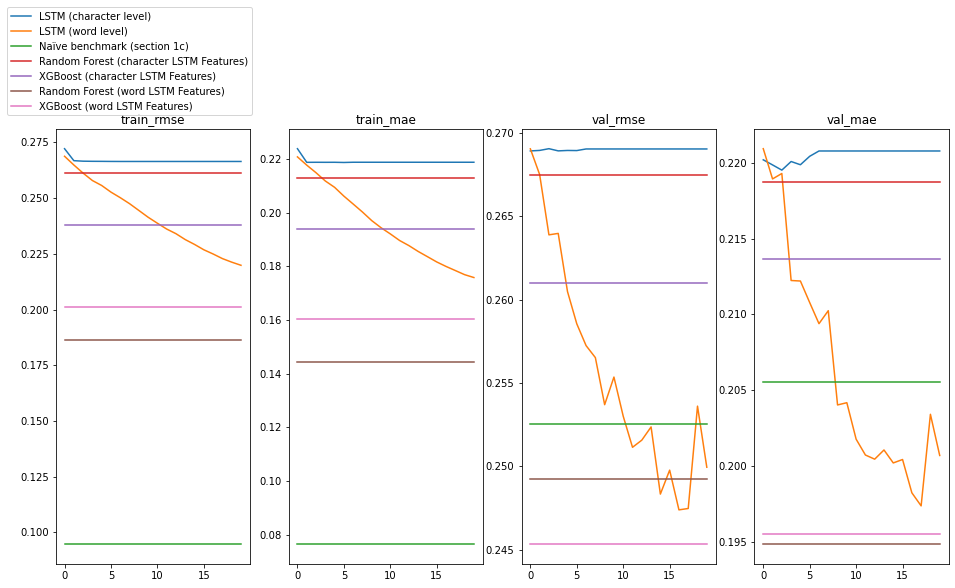

In [290]:
plot_compare(histories, train_vals, names)

# 4. Final Report